In [5]:
%load_ext autoreload
%autoreload 2
%aimport

!nvidia-smi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

Wed Mar 31 01:37:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   41C    P0    48W / 300W |   1608MiB / 16160MiB |     16%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+----------------------

- https://github.com/haqishen/Google-Landmark-Recognition-2020-3rd-Place-Solution
- https://www.kaggle.com/zzy990106/b0-bert-cv0-9
- https://github.com/yang-zhang/product_category/blob/dev/notebooks/transformer_20210307E1--pin_memory.ipynb

In [15]:
HOME = "/data/git/shopee-product-matching"
p_out = f'{HOME}/output/dev0026'
!mkdir -p {p_out}
p_prp = f'{HOME}/output/prep001/train_prep.csv'

FOLD = 0
p_trained = f'{HOME}/output/dev0025'

import sys
sys.path.append(f"{HOME}/src")

import pandas as pd
from pl_model import ShpModel
import os
import torch
import numpy as np
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# load model

In [3]:
ls -hl {p_trained}/tensorboard_csv/*/checkpoints/*.ckpt

-rw-rw-r-- 1 ubuntu ubuntu 736M Mar 30 18:45 '/data/git/shopee-product-matching/output/dev0025/tensorboard_csv/0_0/checkpoints/epoch=2-step=20.ckpt'
-rw-rw-r-- 1 ubuntu ubuntu 736M Mar 30 19:09 '/data/git/shopee-product-matching/output/dev0025/tensorboard_csv/2_2/checkpoints/epoch=2-step=3426.ckpt'
-rw-rw-r-- 1 ubuntu ubuntu 736M Mar 30 20:15 '/data/git/shopee-product-matching/output/dev0025/tensorboard_csv/3_3/checkpoints/epoch=5-step=8565.ckpt'
-rw-rw-r-- 1 ubuntu ubuntu 736M Mar 30 20:41 '/data/git/shopee-product-matching/output/dev0025/tensorboard_csv/4_4/checkpoints/epoch=0-step=1712.ckpt'
-rw-rw-r-- 1 ubuntu ubuntu 736M Mar 30 23:02 '/data/git/shopee-product-matching/output/dev0025/tensorboard_csv/5_5/checkpoints/epoch=28-step=12440.ckpt'


In [4]:
device = torch.device('cuda')

shpmodel = ShpModel.load_from_checkpoint(f'{p_trained}/tensorboard_csv/5_5/checkpoints/epoch=28-step=12440.ckpt')
shpmodel = shpmodel.eval()
shpmodel = shpmodel.to(device)

# dataloader

In [7]:
from dataset import ShopeeDataset, get_transforms
from torch.utils.data import DataLoader

df = pd.read_csv(p_prp)

pids = df.posting_id.values

tfms_trn, tfms_val = get_transforms(224)
ds = ShopeeDataset(df, mode="test", transform=tfms_val)
dl = DataLoader(ds,
            batch_size=128,
            num_workers=8,
            pin_memory=True,
        )

# get feats

In [12]:
for dat in dl:
    dat = dat.to(device)
    with torch.no_grad():
        feat = shpmodel(dat)
    break

feat.shape

torch.Size([128, 512])

In [20]:
feats = np.zeros((len(ds), feat.shape[1]))
i = 0
for dat in tqdm(dl):
    with torch.no_grad():
        dat = dat.to(device)
        output = shpmodel(dat)
        l = len(output)
        feats[i : i + l, :] = output.cpu().detach().numpy()
        i += l

100%|██████████| 268/268 [01:53<00:00,  2.37it/s]


In [21]:
feats.shape

(34250, 512)

# verify

In [22]:
feats[:2, :10]

array([[-0.2674464 ,  0.10585532,  0.44035387, -0.07717042,  0.28454405,
         0.10848091,  0.43104553, -0.19476925,  0.038519  ,  0.01156873],
       [ 0.10652903, -0.14746584,  0.10373394, -0.12944949, -0.04392358,
         0.07770011, -0.04198968, -0.18140434,  0.20519102, -0.08004877]])

In [51]:
from utils import meanf1, get_targets, get_preds_by_thrsh, preds2pids
from neighbor import get_nbrs

In [29]:
dists, idx = get_nbrs(feats)

chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


In [66]:
preds = get_preds_by_thrsh(dists, idx, thrsh=2.)
preds = preds2pids(preds, pids)

In [67]:
meanf1(preds,targets)

0.6871231437743067

In [73]:
thrshes = np.linspace(1.75,2.25,num=11)
print(thrshes)

[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]


In [74]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(dists, idx, thrsh)
    preds = preds2pids(preds, pids)
    f1_lst.append(meanf1(preds,targets))

100%|██████████| 11/11 [00:11<00:00,  1.06s/it]


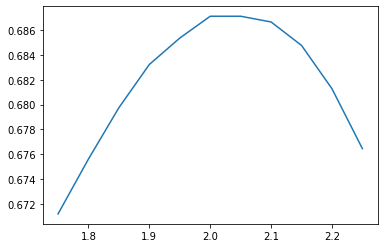

In [75]:
import matplotlib.pyplot as plt
plt.plot(thrshes, f1_lst)  

In [72]:
!nvidia-smi

Wed Mar 31 02:18:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    37W / 300W |   6740MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  